# Exploratory Data Analysis Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from pathlib import Path

import argparse, os
import numpy as np
from scipy import ndimage
from scipy.stats import entropy
from skimage.transform import rescale, resize
#from scipy.misc import imresize
try:
   import rasterio
except ImportError:
   print("ERROR: Could not import Rasterio Python library.")
   print("Check if Rasterio is installed.")

try:
    from skimage.feature import greycomatrix, greycoprops
except ImportError:
    from skimage.feature import graycomatrix, graycoprops

In [2]:
#data_regex = '/adapt/nobackup/projects/ilab/projects/Senegal/CNN_CHM/v2/intersection_tiles_evhrtoa/CAS/image/*.npy'
#label_regex = '/adapt/nobackup/projects/ilab/projects/Senegal/CNN_CHM/v2/intersection_tiles_evhrtoa/CAS/label/*.npy'
data_regex = '/explore/nobackup/projects/ilab/projects/Senegal/CNN_CHM/senegal_20m/v1/intersection_tiles_evhrtoa/CAS/image/*.npy'
label_regex = '/explore/nobackup/projects/ilab/projects/Senegal/CNN_CHM/senegal_20m/v1/intersection_tiles_evhrtoa/CAS/label/*.npy'

In [3]:
data_filenames = glob(data_regex)
label_filenames = glob(label_regex)

In [25]:
import numpy as np
from skimage import io
from scipy import stats
from skimage.feature import greycoprops

def offset(length, angle):
    """Return the offset in pixels for a given length and angle"""
    dv = length * np.sign(-np.sin(angle)).astype(np.int32)
    dh = length * np.sign(np.cos(angle)).astype(np.int32)
    return dv, dh

def crop(img, center, win):
    """Return a square crop of img centered at center (side = 2*win + 1)"""
    row, col = center
    side = 2*win + 1
    first_row = row - win
    first_col = col - win
    last_row = first_row + side    
    last_col = first_col + side
    return img[first_row: last_row, first_col: last_col]

def cooc_maps(img, center, win, d=[1], theta=[0], levels=256):
    """
    Return a set of co-occurrence maps for different d and theta in a square 
    crop centered at center (side = 2*w + 1)
    """
    shape = (2*win + 1, 2*win + 1, len(d), len(theta))
    cooc = np.zeros(shape=shape, dtype=np.int32)
    row, col = center
    Ii = crop(img, (row, col), win)
    for d_index, length in enumerate(d):
        for a_index, angle in enumerate(theta):
            dv, dh = offset(length, angle)
            Ij = crop(img, center=(row + dv, col + dh), win=win)
            cooc[:, :, d_index, a_index] = encode_cooccurrence(Ii, Ij, levels)
    return cooc

def encode_cooccurrence(x, y, levels=256):
    """Return the code corresponding to co-occurrence of intensities x and y"""
    return x*levels + y

def decode_cooccurrence(code, levels=256):
    """Return the intensities x, y corresponding to code"""
    return code//levels, np.mod(code, levels)    

def compute_glcms(cooccurrence_maps, levels=256):
    """Compute the cooccurrence frequencies of the cooccurrence maps"""
    Nr, Na = cooccurrence_maps.shape[2:]
    glcms = np.zeros(shape=(levels, levels, Nr, Na), dtype=np.float64)
    for r in range(Nr):
        for a in range(Na):
            table = stats.itemfreq(cooccurrence_maps[:, :, r, a])
            codes = table[:, 0]
            freqs = table[:, 1]/float(table[:, 1].sum())
            i, j = decode_cooccurrence(codes, levels=levels)
            glcms[i, j, r, a] = freqs
    return glcms

def compute_props(glcms, props=('contrast',)):
    """Return a feature vector corresponding to a set of GLCM"""
    Nr, Na = glcms.shape[2:]
    features = np.zeros(shape=(Nr, Na, len(props)))
    for index, prop_name in enumerate(props):
        features[:, :, index] = greycoprops(glcms, prop_name)
    return features.ravel()

def haralick_features(img, win, d, theta, levels, props):
    """Return a map of Haralick features (one feature vector per pixel)"""
    rows, cols = img.shape
    margin = win + max(d)
    arr = np.pad(img, margin, mode='reflect')
    n_features = len(d) * len(theta) * len(props)
    feature_map = np.zeros(shape=(rows, cols, n_features), dtype=np.float64)
    for m in range(rows):
        for n in range(cols):
            coocs = cooc_maps(arr, (m + margin, n + margin), win, d, theta, levels)
            glcms = compute_glcms(coocs, levels)
            feature_map[m, n, :] = compute_props(glcms, props)
    return feature_map

In [26]:
def rgb2gray(rgb):
    _8bit_c = (rgb / rgb.max()) * 255.
    rgb = np.uint8(_8bit_c)
    r, g, b = rgb[0,:,:], rgb[1,:,:], rgb[2,:,:]
    gray = np.uint8(0.2989 * r + 0.5870 * g + 0.1140 * b)
    return gray

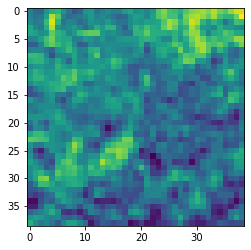

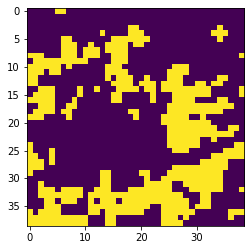

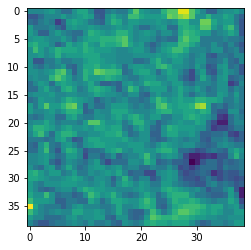

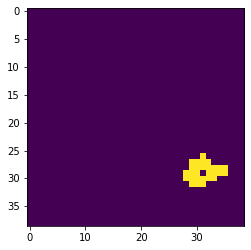

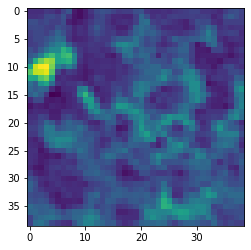

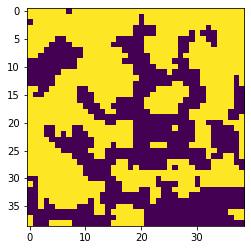

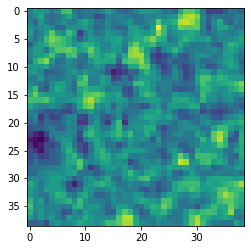

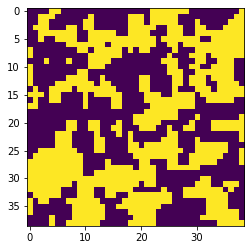

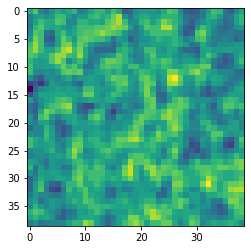

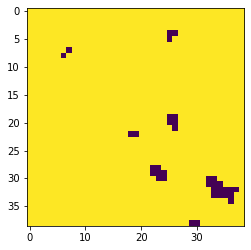

In [6]:
d = (1, 2)
theta = (0, np.pi/4, np.pi/2, 3*np.pi/4)
props = ('contrast', 'homogeneity')
levels = 256
win = 3

for xf, yf in zip(data_filenames[:5], label_filenames[:5]):
    
    # load imagery
    x = np.load(xf)
    y = np.load(yf)
    
    #xx = x.copy()
    
    # grayscale
    #x = rgb2gray(x)
    
    #feature_map = haralick_features(x, win, d, theta, levels, props)  
    #print(feature_map.shape)

    # visualize
    #plt.figure(figsize=(700, 400))

    #subplot(r,c) provide the no. of rows and columns
    #f, axarr = plt.subplots(1,5) 

    # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    #axarr[0].imshow(xx[0, :, :] / 10000.0)
    #axarr[1].imshow(np.squeeze(y))
    #axarr[2].imshow(feature_map[:, :, 0])
    #axarr[3].imshow(feature_map[:, :, 1])
    #axarr[4].imshow(feature_map[:, :, 2])
    plt.imshow(x[0, :, :] / 10000.0)
    plt.show()
    
    plt.imshow(np.squeeze(y))
    plt.show()